In [18]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from sklearn.metrics import jaccard_score
from natsort import natsorted
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import pandas as pd
import seaborn as sns
from skimage.measure import regionprops_table
import zarr

In [19]:
def get_corresponding_label(image, ground_truth_image, label):
    image_label_pixels = image[np.where(ground_truth_image == label)]
    image_label_counts = np.bincount(image_label_pixels)
    corresponding_label = np.argmax(image_label_counts)
    return corresponding_label 

In [20]:
human_seg = []
for img in zarr.open("../../human_annotation_v1_erez/masks/masks.zarr/"):
    if np.sum(img) > 0:
        human_seg.append(img)

In [25]:
syntrained_dirs = natsorted(glob("membrane_segmented_test_images/syn*"))[:]
pretrained_dirs = natsorted(glob("membrane_segmented_test_images/pre*"))[:]
ground_truth_dirs  = natsorted(glob("membrane_test_data/*_masks.png"))[:]
syntrained = []
pretrained = []
ground_truth = []
for syntrained_dir, pretrained_dir, ground_truth_dir in zip(syntrained_dirs, pretrained_dirs, ground_truth_dirs):
    syntrained.append(np.array(Image.open(syntrained_dir)))
    pretrained.append(np.array(Image.open(pretrained_dir)))
    ground_truth.append(np.array(Image.open(ground_truth_dir)))

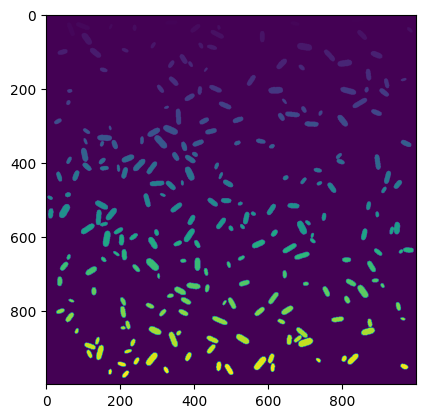

In [28]:
plt.imshow(syntrained[50])

In [29]:
def get_IoUs(ground_truth_segmentation, syntrained_segmentation, pretrained_segmentation):
    ground_truth_labels = np.unique(ground_truth_segmentation)
    syn_IoUs = []
    pre_IoUs = []
    cell_dfs = []
    cell_size = []
    
    ground_truth_regionprops = pd.DataFrame(regionprops_table(ground_truth_segmentation, properties =  ["label", "axis_minor_length", "axis_major_length", "area"]))
    ground_truth_regionprops["Model"] = "Ground truth"
    pretrained_regionprops = pd.DataFrame(regionprops_table(pretrained_segmentation, properties =  ["label", "axis_minor_length", "axis_major_length", "area"]))
    pretrained_regionprops["Model"] = "Pretrained"
    syntrained_regionprops = pd.DataFrame(regionprops_table(syntrained_segmentation, properties =  ["label", "axis_minor_length", "axis_major_length", "area"]))
    syntrained_regionprops["Model"] = "Syntrained"
    
    for ground_truth_label in (ground_truth_labels):
        if ground_truth_label:
            syntrained_label = get_corresponding_label(syntrained_segmentation, ground_truth_segmentation, ground_truth_label)
            pretrained_label = get_corresponding_label(pretrained_segmentation, ground_truth_segmentation, ground_truth_label)
            single_ground_truth_cell = (ground_truth_segmentation == ground_truth_label)
            cell_size.append(np.sum(single_ground_truth_cell))
            if syntrained_label == 0:
                syn_IoU = 0
            else:
                syn_IoU = jaccard_score(single_ground_truth_cell, syntrained_segmentation == syntrained_label, average="micro")

            if pretrained_label == 0:
                pre_IoU = 0
            else:
                pre_IoU = jaccard_score(single_ground_truth_cell, pretrained_segmentation == pretrained_label, average="micro")

            syn_IoUs.append(syn_IoU)
            pre_IoUs.append(pre_IoU)
            
            cell_dfs.append([ground_truth_regionprops.query("label == @ground_truth_label"), syntrained_regionprops.query("label == @syntrained_label"), pretrained_regionprops.query("label == @pretrained_label")])
    
    
    a = 0
    master_cell_df = []
    for cell_df in cell_dfs:
        cell_df = pd.concat(cell_df)
        cell_df["ID"] = a
        master_cell_df.append(cell_df)
        a+=1
    master_cell_df = pd.concat(master_cell_df)
    
    return syn_IoUs, pre_IoUs, cell_size, master_cell_df

In [30]:
IoUs = Parallel(n_jobs=-1)(delayed(get_IoUs)(ground_truth_segmentation, syntrained_segmentation, pretrained_segmentation) for ground_truth_segmentation, syntrained_segmentation, pretrained_segmentation in tqdm(zip(ground_truth, syntrained, pretrained)))

0it [00:00, ?it/s]

In [8]:
syn_IoUs = []
pre_IoUs = []
cell_sizes = []
cell_dfs = []
for syn_IoU, pre_IoU, cell_size, cell_df in IoUs:
    syn_IoUs.extend(syn_IoU)
    pre_IoUs.extend(pre_IoU)
    cell_sizes.extend(cell_size)
    cell_dfs.append(cell_df)

In [9]:
master_cell_df = pd.concat(cell_dfs)
master_cell_df["axis_minor_length"] *= 0.065
master_cell_df["axis_major_length"] *= 0.065
master_cell_df["area"] *= 0.065**2

In [10]:
master_cell_df.to_pickle("omnipose_membrane_size_data.pickle")

<Axes: xlabel='axis_minor_length', ylabel='Density'>

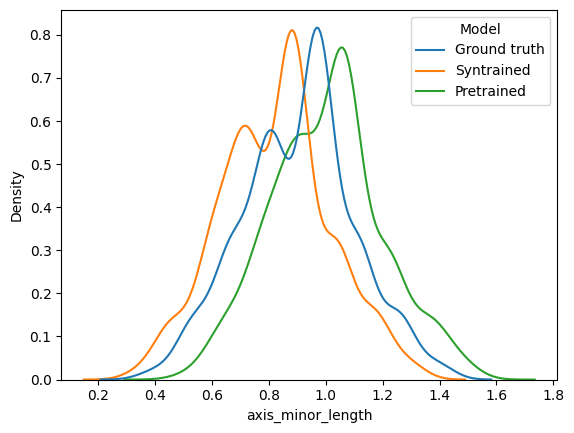

In [11]:
sns.kdeplot(data = master_cell_df, hue = "Model", x = "axis_minor_length", bw_adjust=1.7)

<Axes: xlabel='area', ylabel='Density'>

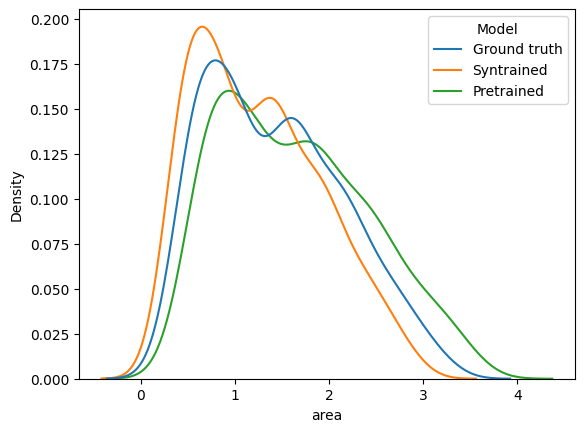

In [12]:
sns.kdeplot(data = master_cell_df, hue = "Model", x = "area", bw_adjust=1.7)

# Width bin vs interpeak distance, and mask width 

In [13]:
IoU_data = pd.DataFrame()
IoU_data["IoU"] = syn_IoUs + pre_IoUs
IoU_data["Cell size"] = cell_sizes + cell_sizes
IoU_data["Model"] = ["Syn-trained"] * len(syn_IoUs) + ["Pretrained"] * len(pre_IoUs)
bins = 7
IoU_data['Cell size (binned)'] = pd.cut(IoU_data["Cell size"], bins=bins, labels=[i for i in sorted([x.mid * (0.065**2) for x in pd.cut(IoU_data["Cell size"], bins=bins).unique()]) ]).astype(float)

In [14]:
IoU_data.to_pickle("../figures/omnipose_membrane_IoU_data.pickle")

In [15]:
IoU_data.groupby(["Cell size (binned)", "Model"]).mean()

IoU   Cell size
Cell size (binned) Model                            
0.488292           Pretrained   0.756550  122.698618
                   Syn-trained  0.733416  122.698618
0.920144           Pretrained   0.808810  215.191159
                   Syn-trained  0.795552  215.191159
1.350490           Pretrained   0.846643  334.021858
                   Syn-trained  0.832200  334.021858
1.780838           Pretrained   0.856985  418.955208
                   Syn-trained  0.846284  418.955208
2.211185           Pretrained   0.866842  519.259740
                   Syn-trained  0.862138  519.259740
2.641531           Pretrained   0.875256  630.641350
                   Syn-trained  0.875573  630.641350
3.071877           Pretrained   0.887436  729.276074
                   Syn-trained  0.883967  729.276074

<Axes: xlabel='Model', ylabel='IoU'>

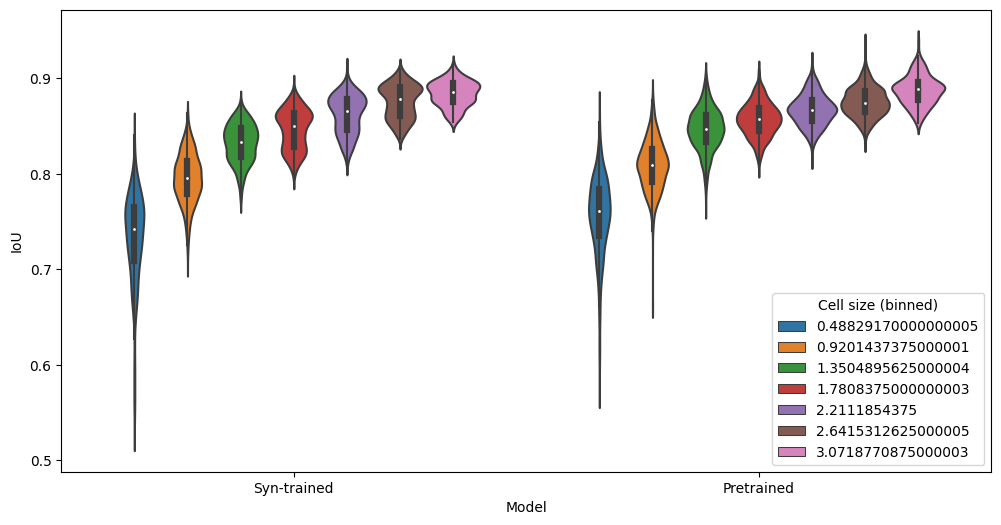

In [16]:
plt.figure(figsize=(12,6))
sns.violinplot(data = IoU_data, x = "Model", y = "IoU", hue="Cell size (binned)", split=False) # generalised IoU

<Axes: xlabel='Model', ylabel='IoU'>

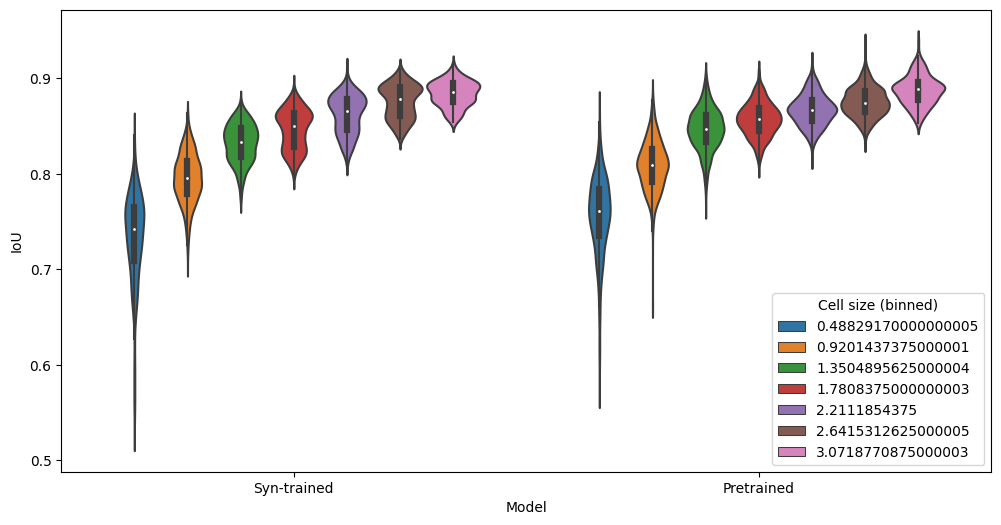

In [17]:
plt.figure(figsize=(12,6))
sns.violinplot(data = IoU_data, x = "Model", y = "IoU", hue="Cell size (binned)", split=False) # generalised IoU